In [40]:
import pandas as pd 
from matplotlib import pyplot as plt
import os
subdirectories = [d for d in os.listdir('../data/raw') if os.path.isdir(os.path.join('../data/raw', d))]
print(subdirectories)

['cursor', 'double_click']


In [41]:
data=[]
for sub in subdirectories:
 data.append(pd.read_csv(f'../data/raw/{sub}/data.csv')) 
data = pd.concat(data, ignore_index=True)
data['Image Path']=data['Image Path'].str[4:]
data.head()

,Gesture,Image Path,T0,T1,T2,T3,Thumb,I3,I2,I1,...,M1,Middle,R3,R2,R1,Ring,L3,L2,L1,Little
0,cursor,_1.png,"342,348","324,335","313,317","311,302","312,290","332,290","318,283","307,292",...,"313,302","311,316","348,292","327,295","322,310","322,324","355,297","335,300","330,312","329,323"
1,cursor,_2.png,"384,290","368,281","355,255","360,234","372,224","363,232","362,207","363,191",...,"370,228","368,238","391,238","385,229","379,248","379,259","403,246","395,239","388,254","387,263"
2,cursor,_3.png,"396,301","378,291","367,266","374,248","387,237","375,251","373,237","373,227",...,"382,238","381,236","402,252","399,240","392,259","390,270","415,257","410,249","403,264","399,273"
3,cursor,_4.png,"398,304","380,293","368,268","373,246","386,234","374,239","373,213","373,198",...,"382,237","379,248","403,245","399,241","392,262","390,272","416,254","409,252","402,268","399,275"
4,cursor,_5.png,"399,309","381,298","369,274","373,254","388,245","375,258","372,243","372,232",...,"383,244","382,245","403,258","399,246","393,264","391,276","417,262","409,256","402,270","399,279"


In [42]:

cols=data.columns[2:]
print(data.head(),cols)

  Gesture Image Path       T0       T1       T2       T3    Thumb       I3  \
0  cursor     _1.png  342,348  324,335  313,317  311,302  312,290  332,290   
1  cursor     _2.png  384,290  368,281  355,255  360,234  372,224  363,232   
2  cursor     _3.png  396,301  378,291  367,266  374,248  387,237  375,251   
3  cursor     _4.png  398,304  380,293  368,268  373,246  386,234  374,239   
4  cursor     _5.png  399,309  381,298  369,274  373,254  388,245  375,258   

        I2       I1  ...       M1   Middle       R3       R2       R1  \
0  318,283  307,292  ...  313,302  311,316  348,292  327,295  322,310   
1  362,207  363,191  ...  370,228  368,238  391,238  385,229  379,248   
2  373,237  373,227  ...  382,238  381,236  402,252  399,240  392,259   
3  373,213  373,198  ...  382,237  379,248  403,245  399,241  392,262   
4  372,243  372,232  ...  383,244  382,245  403,258  399,246  393,264   

      Ring       L3       L2       L1   Little  
0  322,324  355,297  335,300  330,312  329,

In [43]:
#preprocessing step
for col in cols:
    data[[col+'_x',col+'_y']]=data[col].str.split(',',expand=True,)
    data=data.astype({col+'_x':'float64',col+'_y':'float64'})
    data.drop(columns=[col],inplace=True)

data=data.drop_duplicates()

data.to_csv('../data/processed/data.csv',index=False)

print(data.head())
print(cols)  



  Gesture Image Path   T0_x   T0_y   T1_x   T1_y   T2_x   T2_y   T3_x   T3_y  \
0  cursor     _1.png  342.0  348.0  324.0  335.0  313.0  317.0  311.0  302.0   
1  cursor     _2.png  384.0  290.0  368.0  281.0  355.0  255.0  360.0  234.0   
2  cursor     _3.png  396.0  301.0  378.0  291.0  367.0  266.0  374.0  248.0   
3  cursor     _4.png  398.0  304.0  380.0  293.0  368.0  268.0  373.0  246.0   
4  cursor     _5.png  399.0  309.0  381.0  298.0  369.0  274.0  373.0  254.0   

   ...  Ring_x  Ring_y   L3_x   L3_y   L2_x   L2_y   L1_x   L1_y  Little_x  \
0  ...   322.0   324.0  355.0  297.0  335.0  300.0  330.0  312.0     329.0   
1  ...   379.0   259.0  403.0  246.0  395.0  239.0  388.0  254.0     387.0   
2  ...   390.0   270.0  415.0  257.0  410.0  249.0  403.0  264.0     399.0   
3  ...   390.0   272.0  416.0  254.0  409.0  252.0  402.0  268.0     399.0   
4  ...   391.0   276.0  417.0  262.0  409.0  256.0  402.0  270.0     399.0   

   Little_y  
0     323.0  
1     263.0  
2     27

In [ ]:
import cv2
import numpy as np
import os

x = [col + '_x' for col in cols]
y = [col + '_y' for col in cols]
X1, Y2, Y1, X2 = (data[x].min(axis=1) - 8,
                  data[y].max(axis=1) + 30,
                  data[y].min(axis=1) - 15,
                  data[x].max(axis=1) + 8)
df = pd.concat([X1, X2, Y1, Y2],
               axis=1,
               )
df.columns = ['X1', 'X2', 'Y1', 'Y2']
df['path'] = data['Image Path']
df['Gesture'] = data['Gesture']
kernel = np.array([0, -1, 0, -1, 5, -1, 0, -1, 0]).reshape((3, 3))
not_found = []
for index, row in df.iterrows():
    img_path = f'{row["Gesture"]}/images/hand' + row['path']
    ld_img_path = f'{row["Gesture"]}/points/points' + row['path']
    img = cv2.imread('../data/raw/' + img_path)
    ld_img = cv2.imread('../data/raw/' + ld_img_path)
    try:
        if img is None or ld_img is None:
            raise FileNotFoundError(f"Image not found: {img_path} or {ld_img_path}")

        cropped_img = img[int(row['Y1']):int(row['Y2']), int(row['X1']):int(row['X2'])]
        ld_cropped_img = ld_img[int(row['Y1']):int(row['Y2']), int(row['X1']):int(row['X2'])]

        cropped_img = cv2.resize(cropped_img, (50, 50))
        ld_cropped_img = cv2.resize(ld_cropped_img, (50, 50))
        cropped_img = cv2.cvtColor(cropped_img, cv2.COLOR_BGR2GRAY)

        cropped_img = cv2.filter2D(cropped_img, -1, kernel)

        path = "../data/processed/images/" + row['Gesture']
        os.makedirs(path, exist_ok=True)
        cv2.imwrite(path + f'/h{index}.png', cropped_img)
        cv2.imwrite(path + f'/p{index}.png', ld_cropped_img)

    except Exception as e:
        print(e)
        print(img_path)
        not_found.append(index)
data.drop(not_found, inplace=True)
df.drop(not_found, inplace=True)
df.to_csv('../data/processed/bounding_box.csv', index=False)
print(df.head(), df.shape)

OpenCV(4.10.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\resize.cpp:4152: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'

cursor/images/hand_81.png


In [ ]:
data_encoded = pd.get_dummies(data, columns=['Gesture'],prefix='',prefix_sep='')

print(data_encoded.head())

  Image Path   T0_x   T0_y   T1_x   T1_y   T2_x   T2_y   T3_x   T3_y  Thumb_x  \
0     _1.png  342.0  348.0  324.0  335.0  313.0  317.0  311.0  302.0    312.0   
1     _2.png  384.0  290.0  368.0  281.0  355.0  255.0  360.0  234.0    372.0   
2     _3.png  396.0  301.0  378.0  291.0  367.0  266.0  374.0  248.0    387.0   
3     _4.png  398.0  304.0  380.0  293.0  368.0  268.0  373.0  246.0    386.0   
4     _5.png  399.0  309.0  381.0  298.0  369.0  274.0  373.0  254.0    388.0   

   ...   L3_x   L3_y   L2_x   L2_y   L1_x   L1_y  Little_x  Little_y  cursor  \
0  ...  355.0  297.0  335.0  300.0  330.0  312.0     329.0     323.0    True   
1  ...  403.0  246.0  395.0  239.0  388.0  254.0     387.0     263.0    True   
2  ...  415.0  257.0  410.0  249.0  403.0  264.0     399.0     273.0    True   
3  ...  416.0  254.0  409.0  252.0  402.0  268.0     399.0     275.0    True   
4  ...  417.0  262.0  409.0  256.0  402.0  270.0     399.0     279.0    True   

   double_click  
0         Fals

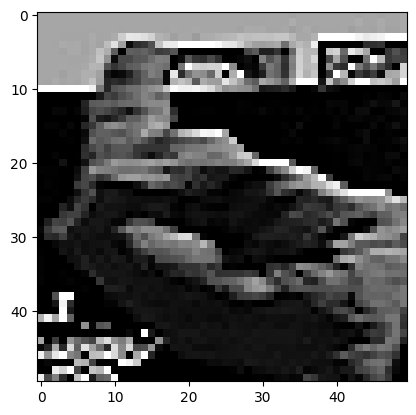

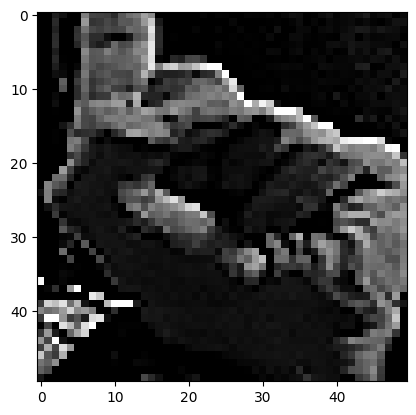

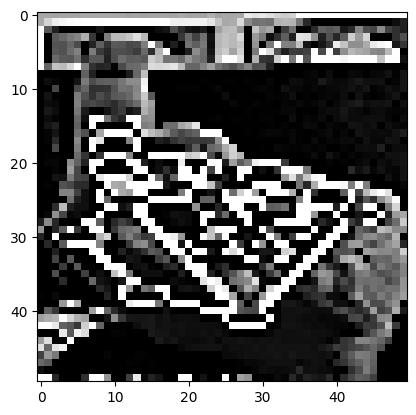

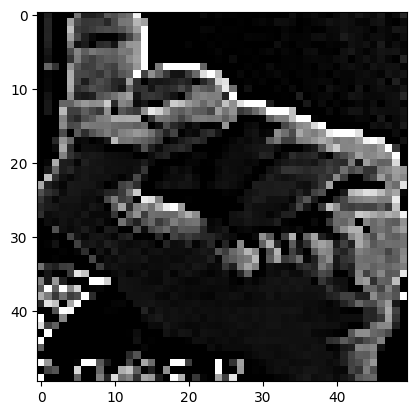

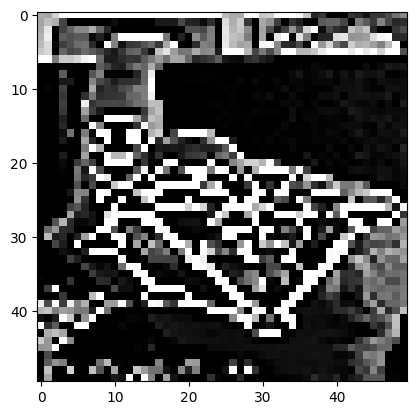

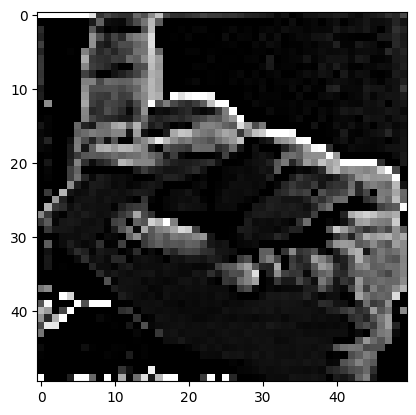

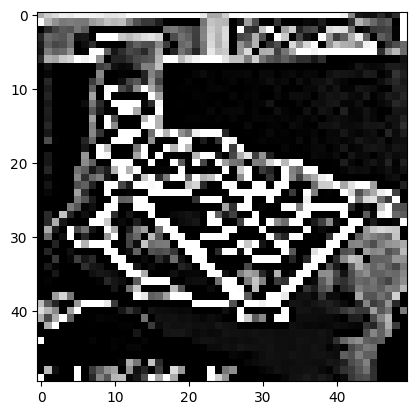

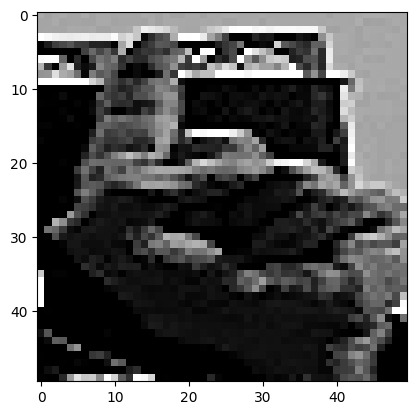

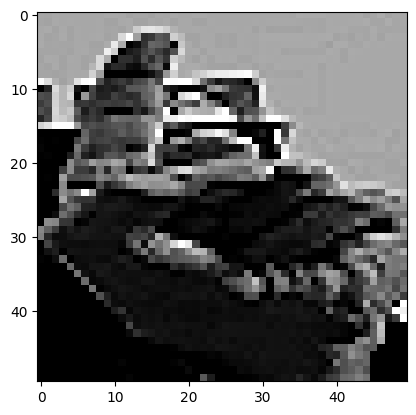

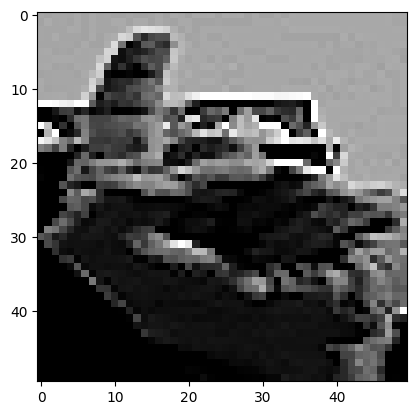

In [ ]:
for img in data['Image Path'][:10]:
    plt.figure()
    img=plt.imread(r'../data/processed/images/cursor/h'+img[1:])
    plt.imshow(img,cmap='gray')

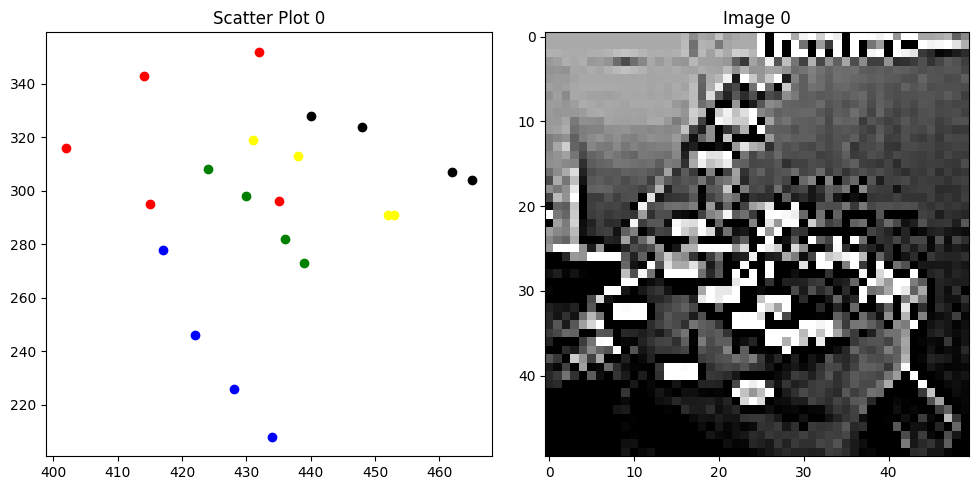

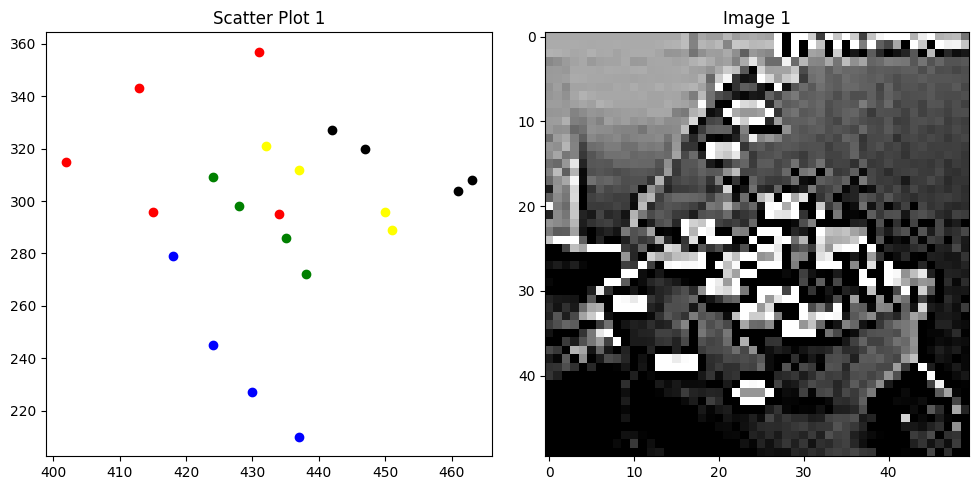

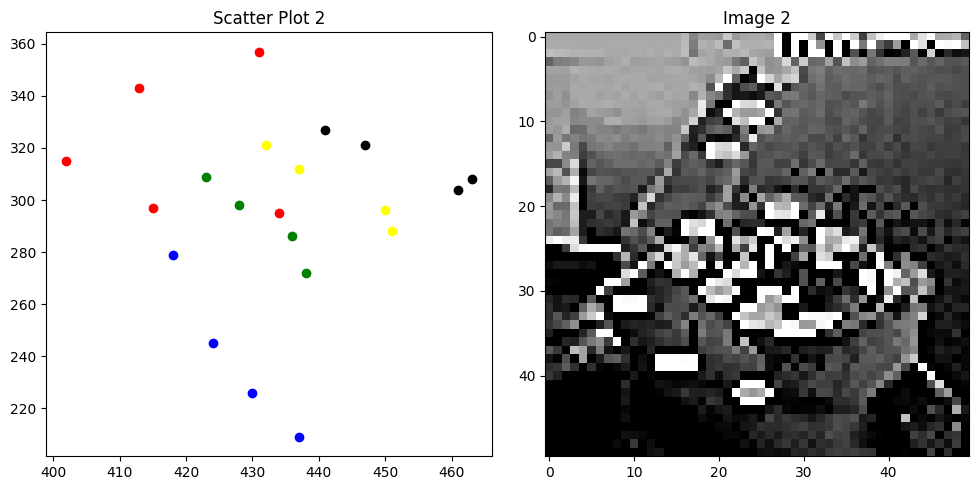

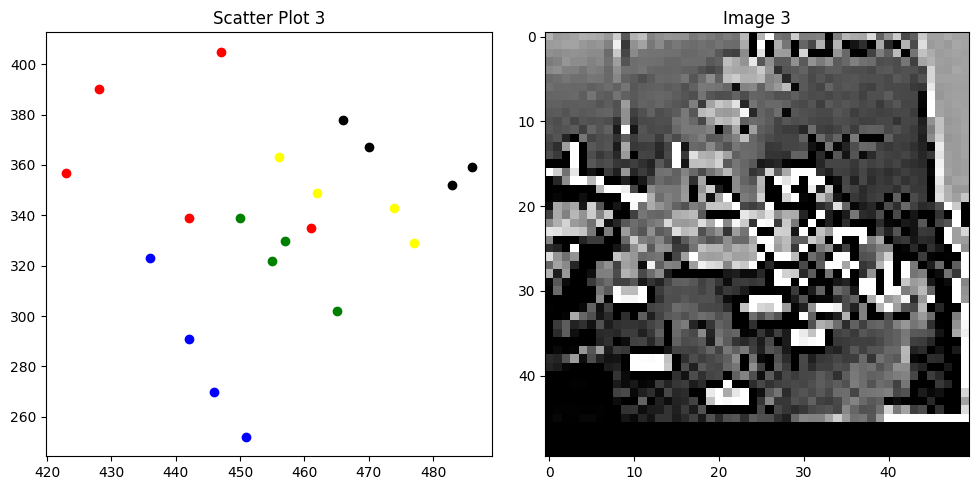

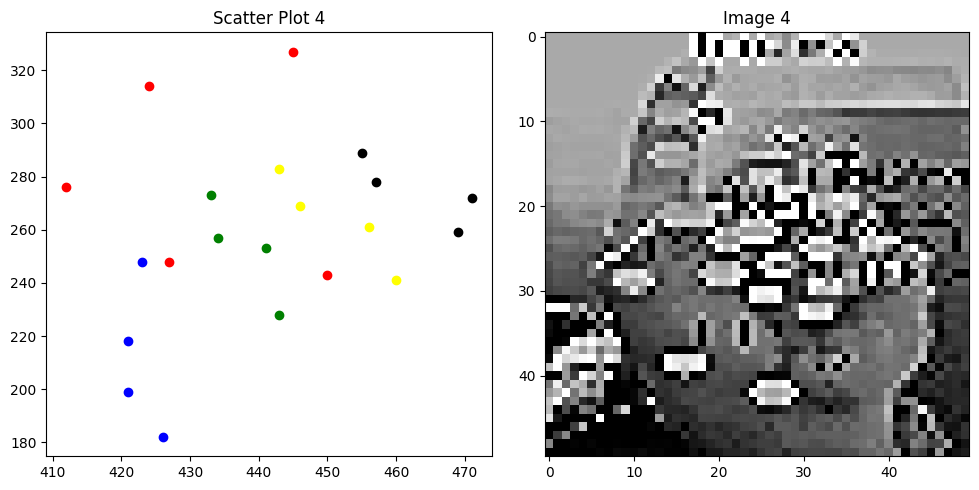

{'T': 'red', 'I': 'blue', 'M': 'green', 'R': 'yellow', 'L': 'black'}

In [ ]:
    
from time import sleep

def scatter_plot():
 col_map={'T':'red','I':'blue','M':'green','R':'yellow','L':'black'} 
 for i in range(5):
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    for col in cols:
        plt.scatter(data.iloc[i][col+'_x'], data.iloc[i][col+'_y'], label=col,color=col_map[col[0]])
    
    img_path = '../data/processed/images/' + data.iloc[i]['Image Path']
    img = plt.imread(img_path)

    plt.title(f'Scatter Plot {i}')
    plt.subplot(1, 2, 2)
    plt.imshow(img,cmap='gray')
    plt.title(f'Image {i}')
    plt.tight_layout()
    plt.show()
    
scatter_plot()

{'T':'red','I':'blue','M':'green','R':'yellow','L':'black'}


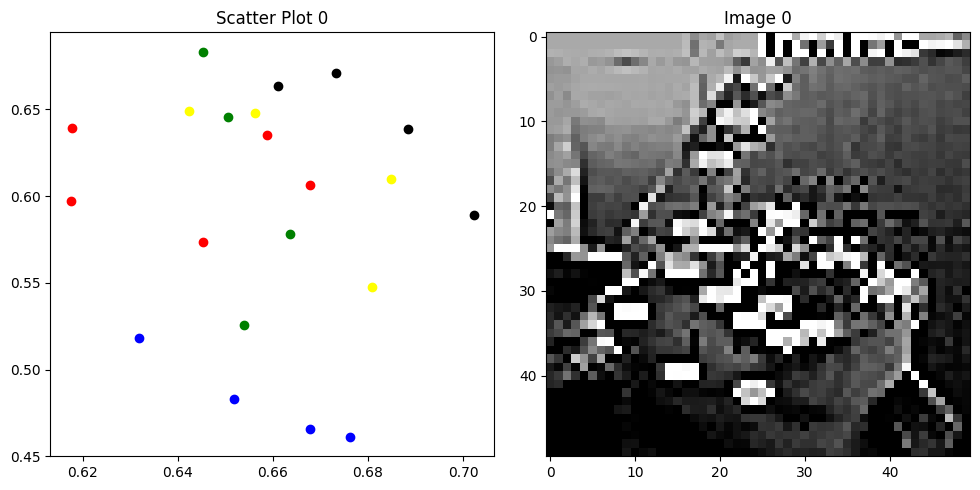

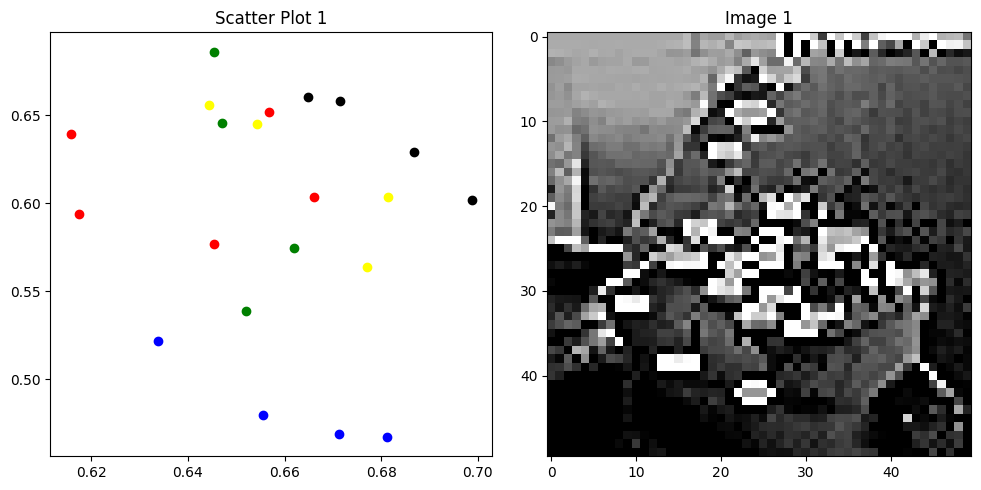

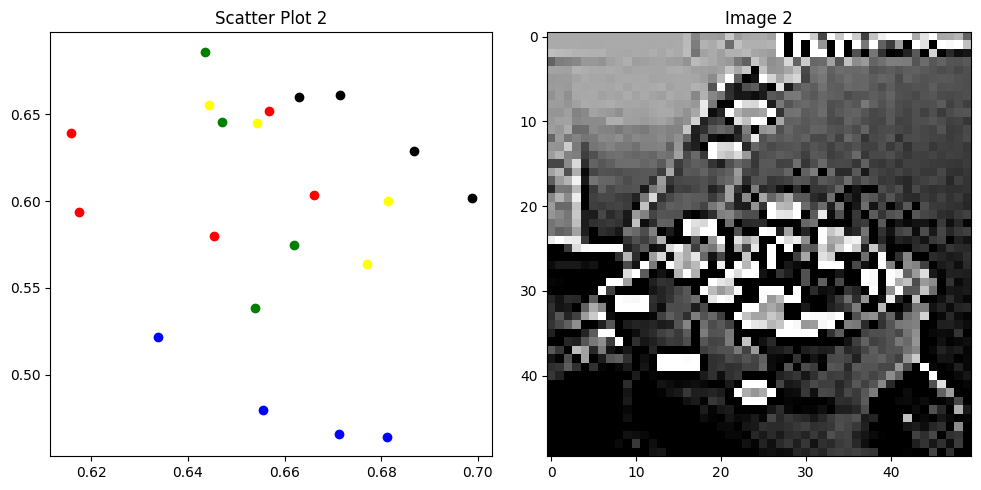

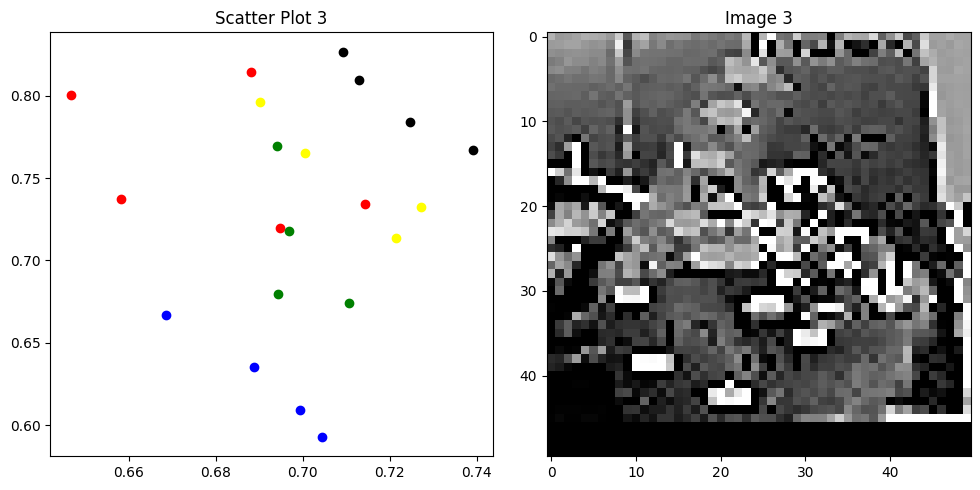

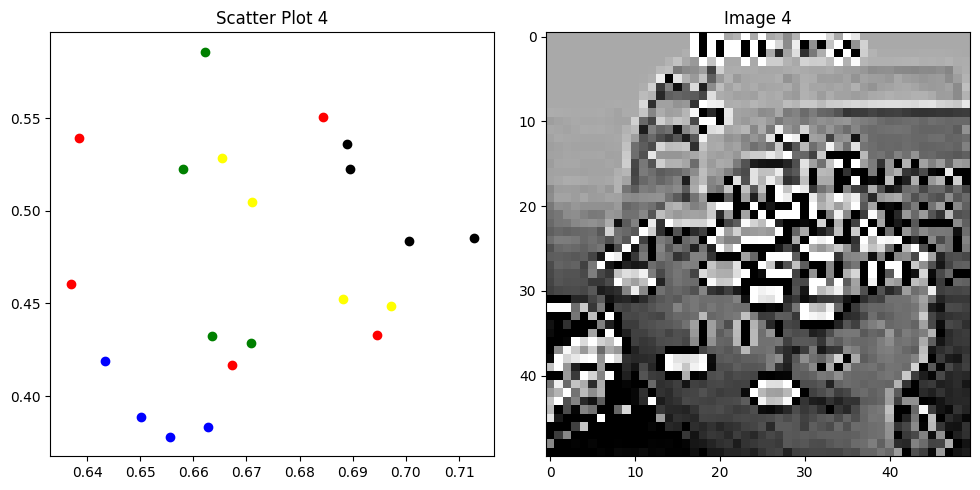

In [ ]:

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
for col in cols:
    data[[col+'_x', col+'_y']] = scaler.fit_transform(data[[col+'_x', col+'_y']])

scatter_plot()

In [ ]:
data.to_csv('../data/processed/sample.csv',index=False)